In [37]:
from utils.EDA.analysis import *
from utils.EDA.visualize import *

In [120]:
def LinearReg(data, target, *features):
    y = np.array(data[target])[np.newaxis].T

    X = np.ones([len(data), 1])
    for feature in features:
        X = np.hstack((X, np.array(data[feature])[np.newaxis].T))

    w, resid, rank, s = np.linalg.lstsq(X, y)

    print("w{} : {}".format("Const", w[0]), end = " ")
    for i in range(len(w)-1):
        print("w{} : {}".format(features[i], w[i+1]), end = " ")
        
    RMSE = np.sqrt(resid / len(data))
    print("\n RMSD : {}".format(RMSE))
    print("rank : {}".format(rank))
    
    # draw chart
    # 예측치와 실제치과의 관계표시(scatter plot)
    predict = np.dot(X, w)
    
    plt.scatter(y, predict)
    plt.xlabel("target value")
    plt.ylabel("predict value")
    plt.xlim(data[target].min(), data[target].max())
    plt.show()

In [20]:
plt.style.use("ggplot")

In [21]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [100]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [113]:
# split datas into quantative and categorical
list_quanToqual = ["MSSubClass", "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars", "MoSold", "YrSold"]

df_train_quan = extractQuanFromDF(df_train, 'Id', 'SalePrice', list_quanToqual)
df_train_qual = extractQualFromDF(df_train, include_list = list_quanToqual)

# 제거할 것 찾기

- 카테고리에서 saleprice분포 차이가 없는 것들

street, Utilities, LotSlope, BldgType, RoofStyle, BsmtFinType1, BsmtFinType2, PavedDrive, Fence, BsmtHalfBath, KichenAbvGr, MoSold, YrSold, 

wConst : [-103449.38429473] wOverallQual : [ 25317.47490684] w1stFlrSF : [ 11.29093204] wGrLivArea : [ 43.38331226] wGarageArea : [ 56.67984178] wTotalBsmtSF : [ 22.95180124] 
 RMSD : [ 39056.72334924]
rank : 6


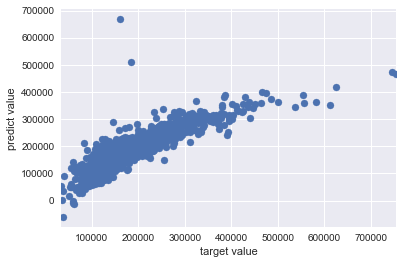

In [124]:
LinearReg(df_train, "SalePrice", "OverallQual", "1stFlrSF", "GrLivArea", "GarageArea", "TotalBsmtSF")

523, 1298

In [115]:
df_train.loc[1298][["SalePrice", "OverallQual",  "1stFlrSF", "GrLivArea", "GarageArea", "TotalBsmtSF"]]

SalePrice      160000
OverallQual        10
1stFlrSF         4692
GrLivArea        5642
GarageArea       1418
TotalBsmtSF      6110
Name: 1298, dtype: object

#### StatsModel를 사용한 선형회귀분석

In [71]:
import statsmodels.api as sm

In [72]:
y = pd.DataFrame(df_train)

In [73]:
model = sm.OLS(y, X)

In [74]:
result = model.fit()

In [76]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     911.5
Date:                Wed, 21 Feb 2018   Prob (F-statistic):               0.00
Time:                        21:13:04   Log-Likelihood:                -17508.
No. Observations:                1460   AIC:                         3.503e+04
Df Residuals:                    1454   BIC:                         3.506e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.034e+05   4938.326    -20.948      0.0